# Imports

In [88]:
import numpy as np
import pandas as pd

import glob
import os

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from xgboost import XGBRFRegressor

from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection import GridSearchCV


import scipy.stats as stats  #for Q-Q plot

import matplotlib.pyplot as plt
import seaborn as sns

import gc

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
all=pd.read_csv('ALL.csv',header=0,index_col=0)

In [3]:
all.head()

,demand,30min,max_temp,min_temp,day_length_mins,isholiday,month,hour,weekend
2016-01-01,5197.34,2016-01-01 00:30:00,24.2,19.8,884.32,0.0,1,1,0
2016-01-01,4934.54,2016-01-01 01:00:00,24.2,19.8,884.32,0.0,1,2,0
2016-01-01,4721.32,2016-01-01 01:30:00,24.2,19.8,884.32,0.0,1,3,0
2016-01-01,4541.24,2016-01-01 02:00:00,24.2,19.8,884.32,0.0,1,4,0
2016-01-01,4344.18,2016-01-01 02:30:00,24.2,19.8,884.32,0.0,1,5,0


In [4]:
features=pd.read_csv('features.csv',header=0,index_col=0)

In [5]:
target=pd.read_csv('target.csv',header=0,index_col=0)

In [6]:
features.head()

,30min,max_temp,min_temp,day_length_mins,isholiday,month,hour,weekend
2016-01-01,2016-01-01 00:30:00,24.2,19.8,884.32,0.0,1,1,0
2016-01-01,2016-01-01 01:00:00,24.2,19.8,884.32,0.0,1,2,0
2016-01-01,2016-01-01 01:30:00,24.2,19.8,884.32,0.0,1,3,0
2016-01-01,2016-01-01 02:00:00,24.2,19.8,884.32,0.0,1,4,0
2016-01-01,2016-01-01 02:30:00,24.2,19.8,884.32,0.0,1,5,0


In [7]:
target.head()

,demand
2016-01-01,5197.34
2016-01-01,4934.54
2016-01-01,4721.32
2016-01-01,4541.24
2016-01-01,4344.18


# 1.Feature Engineering
## 1.1. Outlier detection and removal

Detect any outliers for max_temp,min_temp and day_length_mins by three plots

In [8]:
def diagnostic_plots(df,variable):
    
    plt.figure(figsize=(16,4))
    # histogram
    plt.subplot(1,3,1)
    sns.distplot(df[variable],bins=30)
    plt.title('Histogram')
    
    # Q-Q plot
    plt.subplot(1,3,2)
    stats.probplot(df[variable],dist='norm',plot=plt)
    plt.ylabel('RM quantitles')
    
    # boxplot
    plt.subplot(1,3,3)
    sns.boxplot(y=df[variable])
    plt.title('Boxplot ')
    
    plt.show()

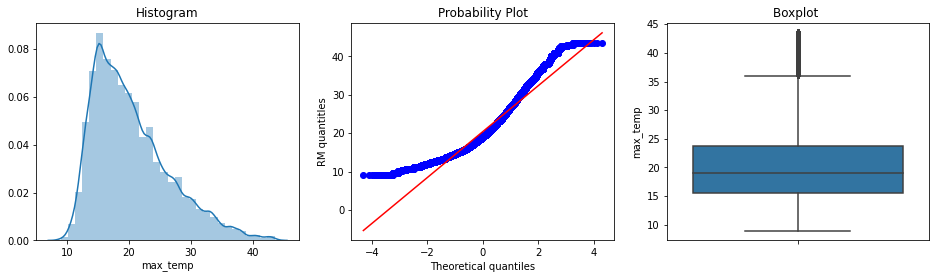

In [9]:
diagnostic_plots(features,'max_temp')

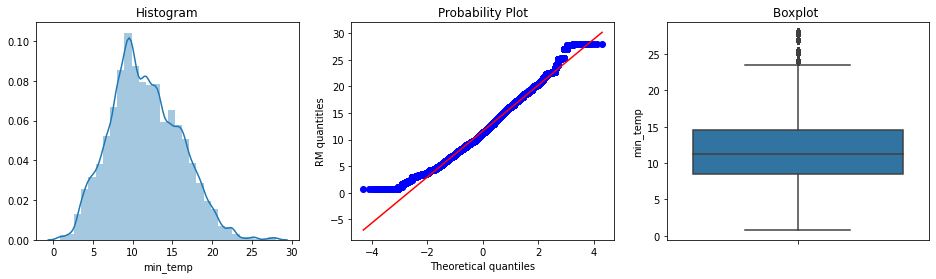

In [10]:
diagnostic_plots(features,'min_temp')

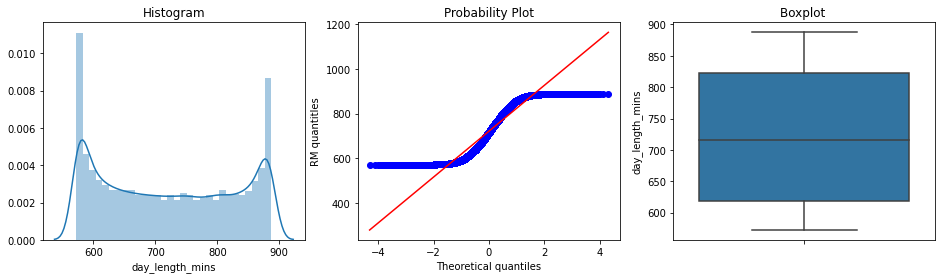

In [11]:
diagnostic_plots(features,'day_length_mins')

max_temp and min_temp both show  outliers on the rights tail.

According to three Standard Deviation Principle, firstly find out the upper and lower boundaries then further capping outilers with upper limit and lower limit.

In [12]:
def find_normal_bound(df,variable,distance):
    upper_bound=df[variable].mean()+distance*df[variable].std()
    lower_bound=df[variable].mean()-distance*df[variable].std()
    
    return upper_bound,lower_bound

In [13]:
features[features.index=='2020-10-11']

,30min,max_temp,min_temp,day_length_mins,isholiday,month,hour,weekend
2020-10-11,2020-10-11 00:00:00,16.0,11.5,773.03,0.0,10,0,1
2020-10-11,2020-10-11 00:30:00,16.0,11.5,773.03,0.0,10,1,1
2020-10-11,2020-10-11 01:00:00,16.0,11.5,773.03,0.0,10,2,1
2020-10-11,2020-10-11 01:30:00,16.0,11.5,773.03,0.0,10,3,1
2020-10-11,2020-10-11 02:00:00,16.0,11.5,773.03,0.0,10,4,1
2020-10-11,2020-10-11 02:30:00,16.0,11.5,773.03,0.0,10,5,1
2020-10-11,2020-10-11 03:00:00,16.0,11.5,773.03,0.0,10,6,1
2020-10-11,2020-10-11 03:30:00,16.0,11.5,773.03,0.0,10,7,1
2020-10-11,2020-10-11 04:00:00,16.0,11.5,773.03,0.0,10,8,1
2020-10-11,2020-10-11 04:30:00,16.0,11.5,773.03,0.0,10,9,1


In [14]:
max_temp_train_ub,max_temp_train_lb=find_normal_bound(features,'max_temp',3)

In [15]:
min_temp_train_ub,min_temp_train_lb=find_normal_bound(features,'min_temp',3)

In [16]:
features['max_temp']=np.where(features['max_temp']>max_temp_train_ub,max_temp_train_ub,
                            np.where(features['max_temp']<max_temp_train_lb,max_temp_train_lb,features['max_temp']))

In [17]:
features['min_temp']=np.where(features['min_temp']>min_temp_train_ub,min_temp_train_ub,
                            np.where(features['min_temp']<min_temp_train_lb,min_temp_train_lb,features['min_temp']))

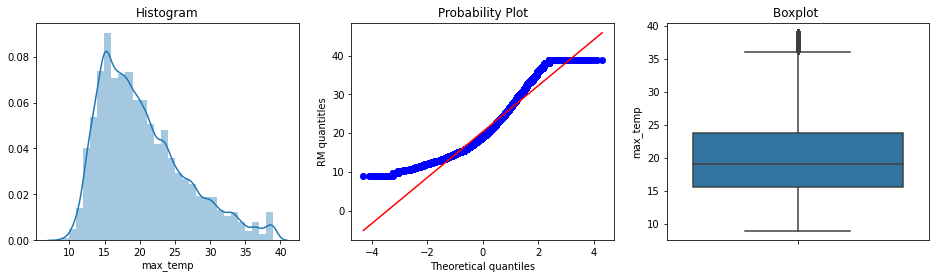

In [18]:
diagnostic_plots(features,'max_temp')

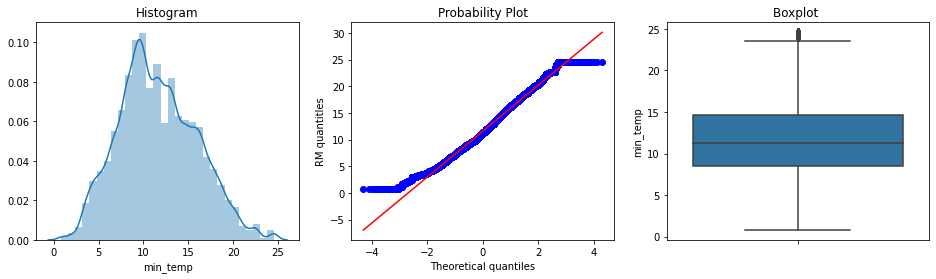

In [19]:
diagnostic_plots(features,'min_temp')

In [20]:
features[features.index=='2020-10-11']

,30min,max_temp,min_temp,day_length_mins,isholiday,month,hour,weekend
2020-10-11,2020-10-11 00:00:00,16.0,11.5,773.03,0.0,10,0,1
2020-10-11,2020-10-11 00:30:00,16.0,11.5,773.03,0.0,10,1,1
2020-10-11,2020-10-11 01:00:00,16.0,11.5,773.03,0.0,10,2,1
2020-10-11,2020-10-11 01:30:00,16.0,11.5,773.03,0.0,10,3,1
2020-10-11,2020-10-11 02:00:00,16.0,11.5,773.03,0.0,10,4,1
2020-10-11,2020-10-11 02:30:00,16.0,11.5,773.03,0.0,10,5,1
2020-10-11,2020-10-11 03:00:00,16.0,11.5,773.03,0.0,10,6,1
2020-10-11,2020-10-11 03:30:00,16.0,11.5,773.03,0.0,10,7,1
2020-10-11,2020-10-11 04:00:00,16.0,11.5,773.03,0.0,10,8,1
2020-10-11,2020-10-11 04:30:00,16.0,11.5,773.03,0.0,10,9,1


In [21]:
features.head()

,30min,max_temp,min_temp,day_length_mins,isholiday,month,hour,weekend
2016-01-01,2016-01-01 00:30:00,24.2,19.8,884.32,0.0,1,1,0
2016-01-01,2016-01-01 01:00:00,24.2,19.8,884.32,0.0,1,2,0
2016-01-01,2016-01-01 01:30:00,24.2,19.8,884.32,0.0,1,3,0
2016-01-01,2016-01-01 02:00:00,24.2,19.8,884.32,0.0,1,4,0
2016-01-01,2016-01-01 02:30:00,24.2,19.8,884.32,0.0,1,5,0


## 1.2 Split data 
<span style='color:red'>Use Jan 2016-Dec 2019 to predict 2020 demand</span>

In [22]:
features.index=pd.to_datetime(features.index)

In [23]:
features=features.drop(columns=['30min'],axis=1)

In [24]:
features.head()

,max_temp,min_temp,day_length_mins,isholiday,month,hour,weekend
2016-01-01,24.2,19.8,884.32,0.0,1,1,0
2016-01-01,24.2,19.8,884.32,0.0,1,2,0
2016-01-01,24.2,19.8,884.32,0.0,1,3,0
2016-01-01,24.2,19.8,884.32,0.0,1,4,0
2016-01-01,24.2,19.8,884.32,0.0,1,5,0


In [25]:
features[(features.index.year>=2020) & (features.index.month==10) ].count()

max_temp           1392
min_temp           1392
day_length_mins    1392
isholiday          1392
month              1392
hour               1392
weekend            1392
dtype: int64

In [26]:
nobs=1296

In [27]:
X_train =features.iloc[0:-nobs]
X_test= features.iloc[-nobs:]

In [28]:
y_train = target.iloc[0:-nobs]
y_test= target.iloc[-nobs:]

In [29]:
y_test.head()

,demand
2020-10-03,4481.78
2020-10-03,4308.78
2020-10-03,4147.20
2020-10-03,4021.30
2020-10-03,3846.39


In [30]:
y_train.head()

,demand
2016-01-01,5197.34
2016-01-01,4934.54
2016-01-01,4721.32
2016-01-01,4541.24
2016-01-01,4344.18


In [31]:
X_train.head()

,max_temp,min_temp,day_length_mins,isholiday,month,hour,weekend
2016-01-01,24.2,19.8,884.32,0.0,1,1,0
2016-01-01,24.2,19.8,884.32,0.0,1,2,0
2016-01-01,24.2,19.8,884.32,0.0,1,3,0
2016-01-01,24.2,19.8,884.32,0.0,1,4,0
2016-01-01,24.2,19.8,884.32,0.0,1,5,0


In [32]:
X_test.head()

,max_temp,min_temp,day_length_mins,isholiday,month,hour,weekend
2020-10-03,29.4,17.4,753.72,0.0,10,0,1
2020-10-03,29.4,17.4,753.72,0.0,10,1,1
2020-10-03,29.4,17.4,753.72,0.0,10,2,1
2020-10-03,29.4,17.4,753.72,0.0,10,3,1
2020-10-03,29.4,17.4,753.72,0.0,10,4,1


## 1.3 Scaling 

In [33]:
# Fit the scaler only on the training data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Scale the testing data also
X_test = scaler.transform(X_test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# 2. Model fitting

Save all the actual demand into a dataframe: demand_actual

In [34]:
all.head()

,demand,30min,max_temp,min_temp,day_length_mins,isholiday,month,hour,weekend
2016-01-01,5197.34,2016-01-01 00:30:00,24.2,19.8,884.32,0.0,1,1,0
2016-01-01,4934.54,2016-01-01 01:00:00,24.2,19.8,884.32,0.0,1,2,0
2016-01-01,4721.32,2016-01-01 01:30:00,24.2,19.8,884.32,0.0,1,3,0
2016-01-01,4541.24,2016-01-01 02:00:00,24.2,19.8,884.32,0.0,1,4,0
2016-01-01,4344.18,2016-01-01 02:30:00,24.2,19.8,884.32,0.0,1,5,0


In [35]:
all.iloc[-len(y_test):].index

Index(['2020-10-03', '2020-10-03', '2020-10-03', '2020-10-03', '2020-10-03',
       '2020-10-03', '2020-10-03', '2020-10-03', '2020-10-03', '2020-10-03',
       ...
       '2020-10-29', '2020-10-29', '2020-10-29', '2020-10-29', '2020-10-29',
       '2020-10-29', '2020-10-29', '2020-10-29', '2020-10-29', '2020-10-29'],
      dtype='object', length=1296)

In [36]:
all['30min']=pd.to_datetime(all['30min'])

In [37]:
all['30min'].dtype

dtype('<M8[ns]')

In [38]:
demand_actual=pd.DataFrame(data=y_test,index=all['30min'].iloc[-len(y_test):],columns=['Actual Demand'])

In [39]:
demand_actual.index=pd.to_datetime(demand_actual.index)

In [40]:
demand_actual.index

DatetimeIndex(['2020-10-03 00:00:00', '2020-10-03 00:30:00',
               '2020-10-03 01:00:00', '2020-10-03 01:30:00',
               '2020-10-03 02:00:00', '2020-10-03 02:30:00',
               '2020-10-03 03:00:00', '2020-10-03 03:30:00',
               '2020-10-03 04:00:00', '2020-10-03 04:30:00',
               ...
               '2020-10-29 19:00:00', '2020-10-29 19:30:00',
               '2020-10-29 20:00:00', '2020-10-29 20:30:00',
               '2020-10-29 21:00:00', '2020-10-29 21:30:00',
               '2020-10-29 22:00:00', '2020-10-29 22:30:00',
               '2020-10-29 23:00:00', '2020-10-29 23:30:00'],
              dtype='datetime64[ns]', name='30min', length=1296, freq=None)

## 2.1 Decision Tree

In [41]:
clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)

print(f'Mean Squared Error: {mean_squared_error(y_test, preds)}')
print(f'Mean absolute Error: {mean_absolute_error(y_test, preds)}')


Mean Squared Error: 268026.11562276236
Mean absolute Error: 379.96352623456795


In [42]:
demand_actual.head()

,Actual Demand
30min,
2020-10-03 00:00:00,4481.78
2020-10-03 00:30:00,4308.78
2020-10-03 01:00:00,4147.20
2020-10-03 01:30:00,4021.30
2020-10-03 02:00:00,3846.39


In [43]:
DecisionTree_preds=pd.DataFrame(data=preds,index=all['30min'].iloc[-len(y_test):],columns=['Decision Tree Predictions'])

In [44]:
DecisionTree_preds.head()

,Decision Tree Predictions
30min,
2020-10-03 00:00:00,4548.42
2020-10-03 00:30:00,4011.82
2020-10-03 01:00:00,3864.20
2020-10-03 01:30:00,3728.46
2020-10-03 02:00:00,3580.18


In [45]:
DecisionTree_preds.tail()

,Decision Tree Predictions
30min,
2020-10-29 21:30:00,4646.24
2020-10-29 22:00:00,4587.86
2020-10-29 22:30:00,4300.62
2020-10-29 23:00:00,4249.91
2020-10-29 23:30:00,4319.08


In [46]:
DecisionTree_preds.index=pd.to_datetime(DecisionTree_preds.index)

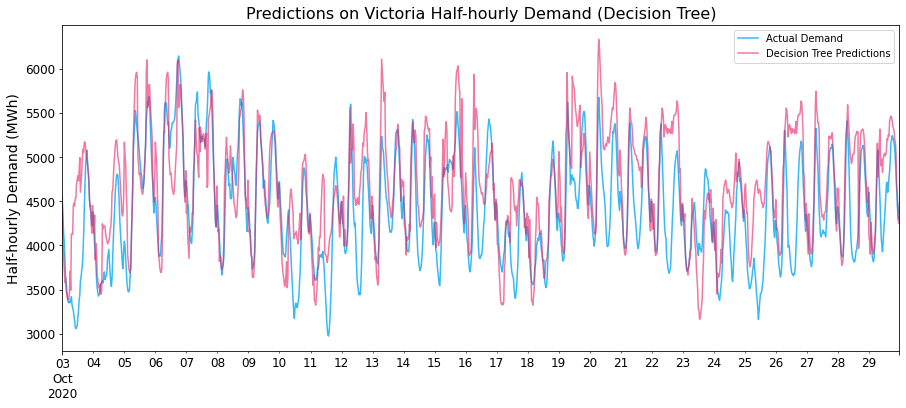

In [47]:
title='Predictions on Victoria Half-hourly Demand (Decision Tree)'
ylabel='Half-hourly Demand (MWh)'
xlabel=''

ax = demand_actual.plot(legend=True,figsize=(15,6),fontsize=12,color='#03A9F4',alpha=0.8)
DecisionTree_preds['Decision Tree Predictions'].plot(legend=True,color='#E91E63',alpha=0.6)
ax.autoscale(axis='x',tight=True)
plt.title(title,fontsize=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel,fontsize=14);

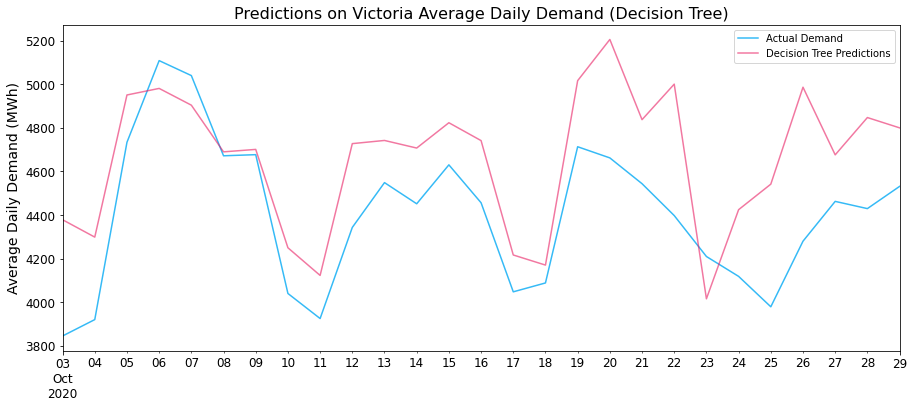

In [51]:
title='Predictions on Victoria Average Daily Demand (Decision Tree)'
ylabel='Average Daily Demand (MWh)'
xlabel=''

ax = demand_actual.resample(rule='D').mean().plot(legend=True,figsize=(15,6),fontsize=12,color='#03A9F4',alpha=0.8)
DecisionTree_preds['Decision Tree Predictions'].resample(rule='D').mean().plot(legend=True,color='#E91E63',alpha=0.6)
ax.autoscale(axis='x',tight=True)
plt.title(title,fontsize=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel,fontsize=14);

## 2.2 KNN

In [75]:
knn = KNeighborsRegressor(5)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)

print(f'Mean Squared Error: {mean_squared_error(y_test, preds)}')
print(f'Mean absolute Error: {mean_absolute_error(y_test, preds)}')


Mean Squared Error: 220513.66175695986
Mean absolute Error: 350.0952515432099


In [76]:
KNN_preds=pd.DataFrame(data=preds,index=all['30min'].iloc[-len(y_test):],columns=['KNN Predictions'])

In [77]:
KNN_preds.tail()

,KNN Predictions
30min,
2020-10-29 21:30:00,4700.668
2020-10-29 22:00:00,4567.700
2020-10-29 22:30:00,4516.732
2020-10-29 23:00:00,4516.732
2020-10-29 23:30:00,4450.520


In [78]:
KNN_preds.index=pd.to_datetime(KNN_preds.index)

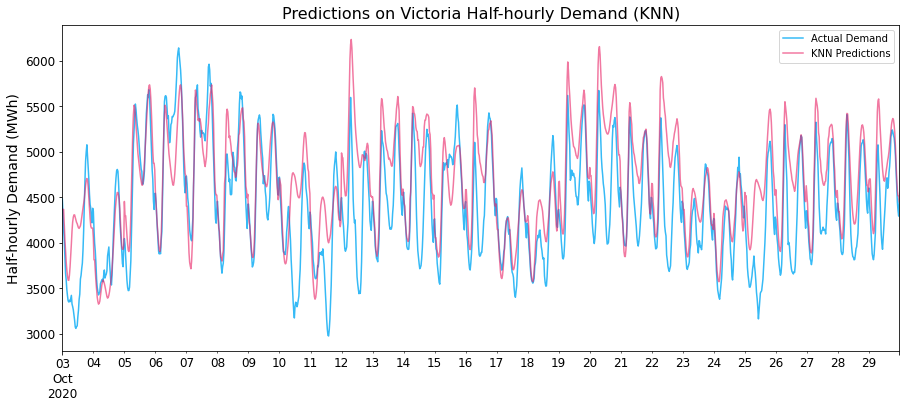

In [79]:
title='Predictions on Victoria Half-hourly Demand (KNN)'
ylabel='Half-hourly Demand (MWh)'
xlabel=''

ax = demand_actual.plot(legend=True,figsize=(15,6),fontsize=12,color='#03A9F4',alpha=0.8)
KNN_preds['KNN Predictions'].plot(legend=True,color='#E91E63',alpha=0.6)
ax.autoscale(axis='x',tight=True)
plt.title(title,fontsize=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel,fontsize=14);

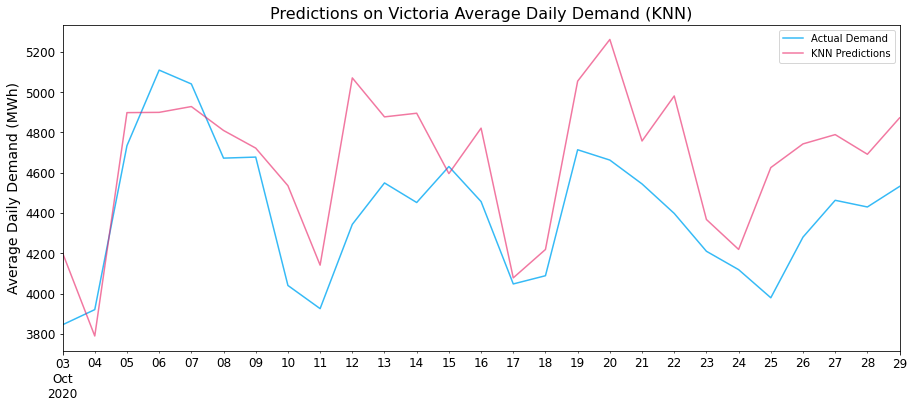

In [80]:
title='Predictions on Victoria Average Daily Demand (KNN)'
ylabel='Average Daily Demand (MWh)'
xlabel=''

ax = demand_actual.resample(rule='D').mean().plot(legend=True,figsize=(15,6),fontsize=12,color='#03A9F4',alpha=0.8)
KNN_preds['KNN Predictions'].resample(rule='D').mean().plot(legend=True,color='#E91E63',alpha=0.6)
ax.autoscale(axis='x',tight=True)
plt.title(title,fontsize=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel,fontsize=14);

Decision Tree\
Mean Squared Error: 268026.11562276236\
Mean absolute Error: 379.96352623456795

KNN\
Mean Squared Error: 220513.66175695986\
Mean absolute Error: 350.0952515432099

XGBoost\
Mean Squared Error: 197789.09567795668\
Mean absolute Error: 329.26792005750866
    

## 2.3 XGBoost

Just use the default parameters to see which model is with better performance.

In [120]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

[22:41:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [121]:
print(f'Mean Squared Error: {mean_squared_error(y_test, preds)}')
print(f'Mean absolute Error: {mean_absolute_error(y_test, preds)}')

Mean Squared Error: 197789.09567795668
Mean absolute Error: 329.26792005750866


In [122]:
XGBoost_preds=pd.DataFrame(data=preds,index=all['30min'].iloc[-len(y_test):],columns=['XGBoost Predictions'])

In [123]:
XGBoost_preds.index=pd.to_datetime(XGBoost_preds.index)

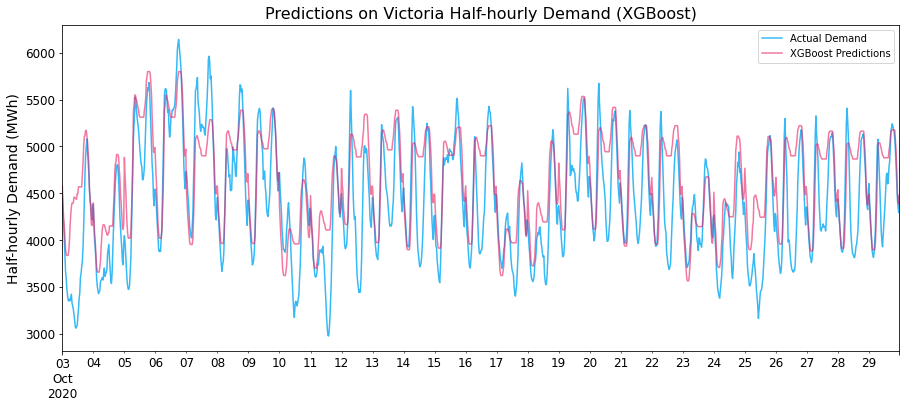

In [124]:
title='Predictions on Victoria Half-hourly Demand (XGBoost)'
ylabel='Half-hourly Demand (MWh)'
xlabel=''

ax = demand_actual.plot(legend=True,figsize=(15,6),fontsize=12,color='#03A9F4',alpha=0.8)
XGBoost_preds['XGBoost Predictions'].plot(legend=True,color='#E91E63',alpha=0.6)
ax.autoscale(axis='x',tight=True)
plt.title(title,fontsize=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel,fontsize=14);

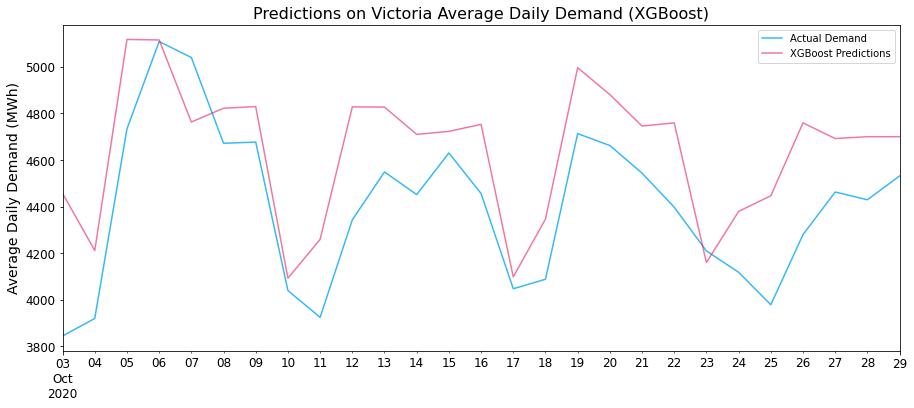

In [125]:
title='Predictions on Victoria Average Daily Demand (XGBoost)'
ylabel='Average Daily Demand (MWh)'
xlabel=''

ax = demand_actual.resample('D').mean().plot(legend=True,figsize=(15,6),fontsize=12,color='#03A9F4',alpha=0.8)
XGBoost_preds['XGBoost Predictions'].resample('D').mean().plot(legend=True,color='#E91E63',alpha=0.6)
ax.autoscale(axis='x',tight=True)
plt.title(title,fontsize=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel,fontsize=14);

## 3 Model Evaluation and Selection

Xgboost has much lower MSE and MAE. Do hyperparameter tuning on XGBoost then fit the model again.

### 3.1 XGBoost hyperparameter tuning

In [89]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [90]:
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 20.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 56.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 104.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 167.3min
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed: 203.9min finished


{'colsample_bytree': 0.7,
 'learning_rate': 0.1,
 'max_depth': 5,
 'min_child_weight': 1,
 'n_estimators': 200,
 'objective': 'reg:squarederror',
 'subsample': 0.5}

<span style='color:red'>Best hyperparameters:</span> \
{'colsample_bytree': 0.7,\
 'learning_rate': 0.1,\
 'max_depth': 5,\
 'min_child_weight': 1,\
 'n_estimators': 200,\
 'objective': 'reg:squarederror',\
 'subsample': 0.5}

### 3.2 Fit and predict demand by the tuned XGBoost

In [93]:
xgb_model = XGBRegressor(objective = 'reg:squarederror',
                         colsample_bytree = 0.7,
                         learning_rate = 0.1,
                         max_depth = 5,
                         min_child_weight = 1,
                         n_estimators = 200,
                         subsample = 0.5)

In [127]:
%time xgb_model.fit(X_train, y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)], verbose=False)

tuned_preds = xgb_model.predict(X_test)

print(f'Mean Squared Error: {mean_squared_error(y_test, tuned_preds)}')
print(f'Mean absolute Error: {mean_absolute_error(y_test, tuned_preds)}')
print(f'Root Mean absolute Error: {np.sqrt(mean_absolute_error(y_test, tuned_preds))}')

Wall time: 2.78 s
Mean Squared Error: 153665.48405685523
Mean absolute Error: 293.07903724199457
Root Mean absolute Error: 17.119551315440326


In [112]:
XGBoost_preds_tuned=pd.DataFrame(data=tuned_preds,index=all['30min'].iloc[-len(y_test):],columns=['Tuned XGBoost Predictions'])

In [113]:
XGBoost_preds_tuned.index=pd.to_datetime(XGBoost_preds_tuned.index)

In [114]:
XGBoost_preds_tuned.head()

,Tuned XGBoost Predictions
30min,
2020-10-03 00:00:00,4375.367676
2020-10-03 00:30:00,4226.898438
2020-10-03 01:00:00,4091.450439
2020-10-03 01:30:00,3988.921875
2020-10-03 02:00:00,3889.990723


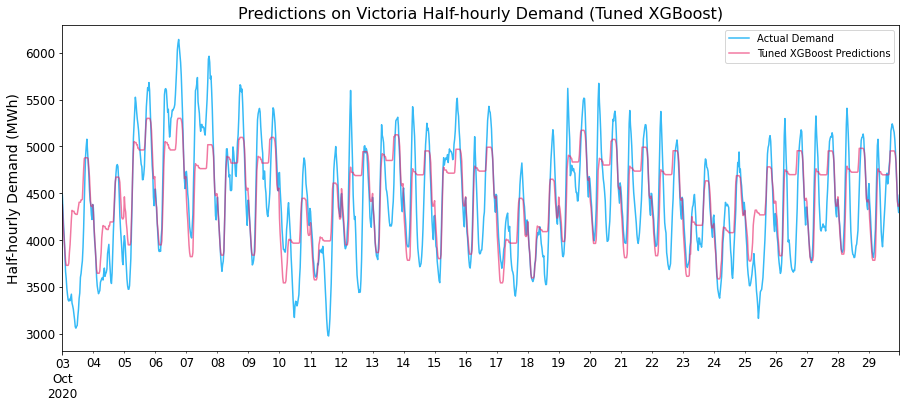

In [115]:
title='Predictions on Victoria Half-hourly Demand (Tuned XGBoost)'
ylabel='Half-hourly Demand (MWh)'
xlabel=''

ax = demand_actual.plot(legend=True,figsize=(15,6),fontsize=12,color='#03A9F4',alpha=0.8)
XGBoost_preds_tuned['Tuned XGBoost Predictions'].plot(legend=True,color='#E91E63',alpha=0.6)
ax.autoscale(axis='x',tight=True)
plt.title(title,fontsize=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel,fontsize=14);

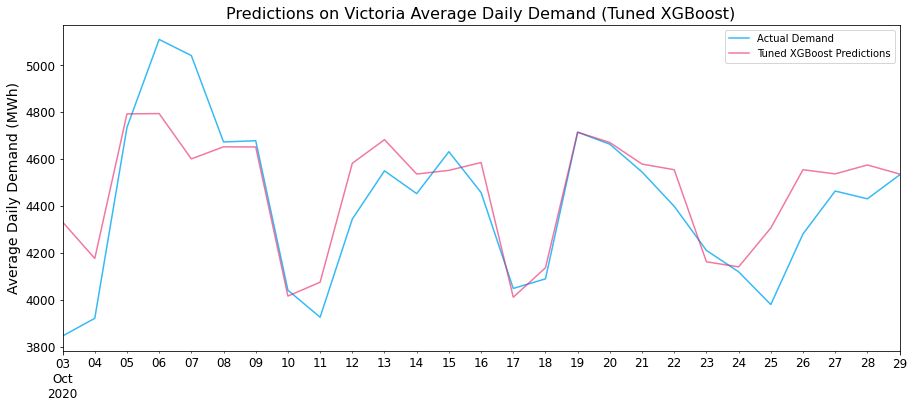

In [126]:
title='Predictions on Victoria Average Daily Demand (Tuned XGBoost)'
ylabel='Average Daily Demand (MWh)'
xlabel=''

ax = demand_actual.resample('D').mean().plot(legend=True,figsize=(15,6),fontsize=12,color='#03A9F4',alpha=0.8)
XGBoost_preds_tuned['Tuned XGBoost Predictions'].resample('D').mean().plot(legend=True,color='#E91E63',alpha=0.6)
ax.autoscale(axis='x',tight=True)
plt.title(title,fontsize=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel,fontsize=14);